# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_13364/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

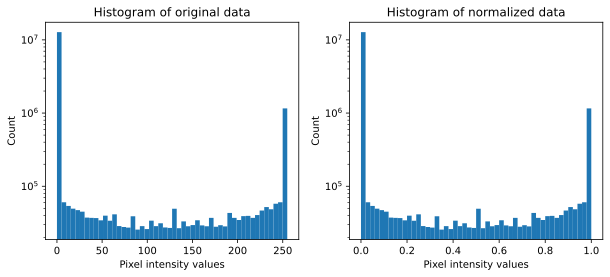

In [3]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>es\\IPython\\display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3037, grad_fn=<NllLossBackward0>)


In [8]:
y

tensor([2, 3, 9, 0, 7, 7, 5, 6, 3, 6, 1, 6, 3, 5, 9, 6, 8, 9, 4, 0, 3, 4, 5, 4,
        8, 5, 2, 6, 1, 6, 6, 4])

# Create a function that trains the model

In [9]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    net.eval()
    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [10]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


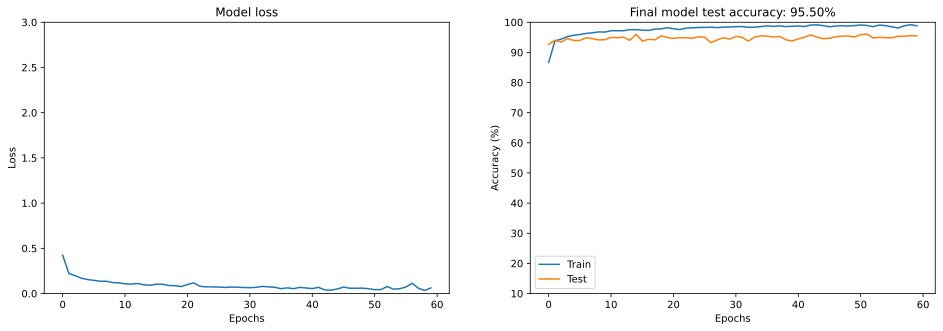

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [12]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[ 0.0000e+00, -1.9791e+02, -3.1704e+01,  ..., -7.4182e+01,
         -8.6616e+01, -8.7565e+01],
        [-5.3193e+01, -7.5093e+01, -1.5586e+02,  ..., -2.8094e+02,
         -5.8872e+01, -6.3295e+01],
        [ 0.0000e+00, -2.2169e+02, -3.5613e+01,  ..., -8.3115e+01,
         -9.7107e+01, -9.8141e+01],
        ...,
        [-5.2035e+01, -2.1831e+01, -2.4187e+01,  ...,  0.0000e+00,
         -7.0897e+01, -2.6490e+01],
        [-1.8748e+01, -3.2442e+01, -3.0395e+01,  ..., -2.5330e+01,
          0.0000e+00, -2.8275e+01],
        [-1.5248e+02, -2.1934e-05, -1.2819e+01,  ..., -1.1392e+01,
         -1.7141e+01, -6.3188e+01]])

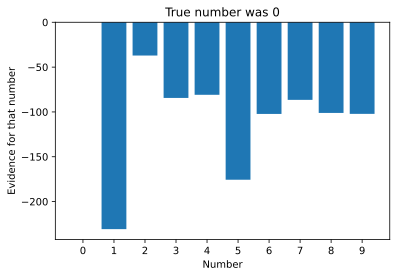

In [13]:
# Evidence for all numbers from one sample
sample2show = 12

plt.bar(range(10),predictions[sample2show]) # try adding exp!
# plt.bar(range(10), np.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  20   24   38   89   92  105  127  183  199  214  225  238  258  264
  267  272  277  334  410  452  467  470  480  558  598  618  620  621
  679  691  709  719  735  868  888  967  971  985 1027 1041 1069 1079
 1108 1151 1225 1251 1267 1286 1361 1394 1406 1409 1427 1435 1448 1455
 1456 1459 1480 1492 1508 1518 1531 1536 1539 1551 1559 1588 1598 1605
 1647 1650 1655 1669 1676 1680 1695 1698 1717 1762 1770 1817 1823 1831
 1835 1850 1916 1920 1969 1985]


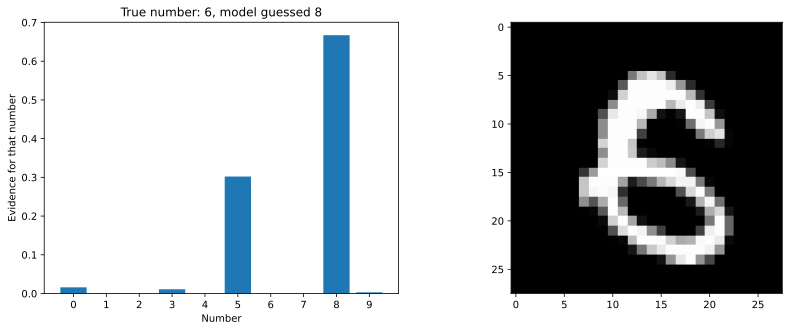

In [14]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

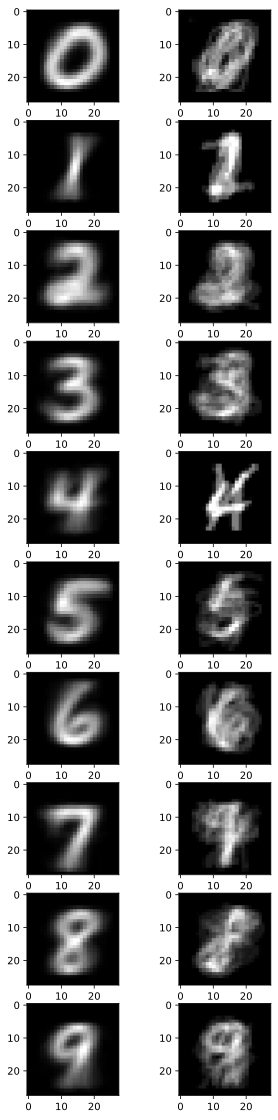

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(5, 20))
ax = ax.flatten()
for i, num in zip(range(0, 20, 2), range(10)):
    corrects = test_data.tensors[0][np.where((torch.max(predictions, axis=1)[1] == y) & (y == num))[0]]
    errors = test_data.tensors[0][np.where((torch.max(predictions, axis=1)[1] != y) & (y == num))[0]]
    corrects_avg = corrects.mean(axis=0)
    errors_avg = errors.mean(axis=0)
    # print(c_labels[1])
    ax[i].imshow( np.reshape(corrects_avg, (28,28)) ,cmap='gray')
    ax[i+1].imshow( np.reshape(errors_avg, (28,28)) ,cmap='gray')

In [34]:
# torch.max(predictions, axis=1)[1]
indicies = np.where((np.exp(predictions) > 0.1).sum(axis=1) > 1)[0]

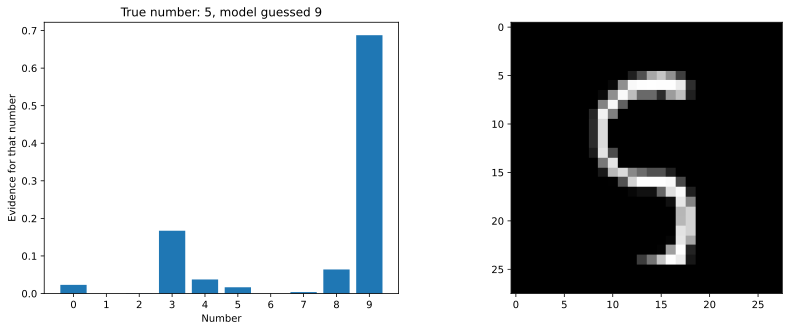

In [37]:
sample2show = indicies[3]

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[sample2show]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[sample2show].item(), torch.argmax(predictions[sample2show]).item() ))

ax[1].imshow( np.reshape(test_data.tensors[0][sample2show],(28,28)) ,cmap='gray')

plt.show()

In [16]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 